## Comparisons study

In this file we will do a comparison between 3 models of collaborative filtering tasks in the context of a movie recommendation algorithm.
- Probability Matrix Factorization (PMF)
- Restricted Bolzmann Machines (RBM)
- Value Auto-Encoder (VAE)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data.preprocess import load_data, get_train_test_split

# Loading
df = load_data()
train_df, test_df = get_train_test_split(df)
n_users, n_items = df.user_id.max()+1, df.item_id.max()+1

### Initialization and traning of the PMF model

In [3]:
from models.pmf import PMF

# Initializing PMF model
pmf_model = PMF(n_users, n_items, n_factors=50)
data_to_train = train_df[['user_id', 'item_id', 'rating']].values

# Training PMF model
pmf_history = pmf_model.fit(data_to_train, epochs=20)

Epoch 1/20 - RMSE: 3.4476
Epoch 2/20 - RMSE: 1.6065
Epoch 3/20 - RMSE: 1.1125
Epoch 4/20 - RMSE: 1.0083
Epoch 5/20 - RMSE: 0.9680
Epoch 6/20 - RMSE: 0.9460
Epoch 7/20 - RMSE: 0.9309
Epoch 8/20 - RMSE: 0.9189
Epoch 9/20 - RMSE: 0.9086
Epoch 10/20 - RMSE: 0.8993
Epoch 11/20 - RMSE: 0.8909
Epoch 12/20 - RMSE: 0.8830
Epoch 13/20 - RMSE: 0.8756
Epoch 14/20 - RMSE: 0.8685
Epoch 15/20 - RMSE: 0.8616
Epoch 16/20 - RMSE: 0.8549
Epoch 17/20 - RMSE: 0.8483
Epoch 18/20 - RMSE: 0.8418
Epoch 19/20 - RMSE: 0.8355
Epoch 20/20 - RMSE: 0.8292


### RBM : Initialization, preprocessing of the ratings data and training

In [4]:
from models.rbm import RBM

# Create the user-item matrix for RBM
train_matrix = np.zeros((n_users, n_items))

# Fill the matrix: 1 if rating >= 4, else 0
for row in train_df.itertuples():
    if row.rating >= 4: train_matrix[row.user_id, row.item_id] = 1

rbm_model = RBM(n_visible=n_items, n_hidden=128)
rbm_history = rbm_model.train(train_matrix, epochs=20)

Epoch 1/20 - Loss: 2.5441
Epoch 2/20 - Loss: 1.4006
Epoch 3/20 - Loss: 1.0285
Epoch 4/20 - Loss: 0.8614
Epoch 5/20 - Loss: 0.7518
Epoch 6/20 - Loss: 0.6948
Epoch 7/20 - Loss: 0.6457
Epoch 8/20 - Loss: 0.6156
Epoch 9/20 - Loss: 0.5852
Epoch 10/20 - Loss: 0.5542
Epoch 11/20 - Loss: 0.5346
Epoch 12/20 - Loss: 0.5185
Epoch 13/20 - Loss: 0.5037
Epoch 14/20 - Loss: 0.5040
Epoch 15/20 - Loss: 0.4951
Epoch 16/20 - Loss: 0.4876
Epoch 17/20 - Loss: 0.4867
Epoch 18/20 - Loss: 0.4836
Epoch 19/20 - Loss: 0.4757
Epoch 20/20 - Loss: 0.4678


### Setup DataLoader + Preprocessing ratings data for VAE

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# On prépare la matrice (Users x Items) - Entrées binaires pour le VAE
# On utilise la même logique que le RBM : note >= 4 -> 1
vae_matrix = np.zeros((n_users, n_items))
for row in train_df.itertuples():
    if row.rating >= 4:
        vae_matrix[row.user_id, row.item_id] = 1

# Conversion en tenseur PyTorch
train_tensor = torch.FloatTensor(vae_matrix)
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=64, shuffle=True)

### VAE training

For this model, the loss function is an ELBO (Evidence Lower Bound) loss function and not a RMSE function like the PMF and the RBM.

In [6]:
from models.vae import VAE, loss_function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model = VAE(n_items=n_items, n_hidden=200, n_latent=64).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3) # Adam optimizer

def train_vae(epochs=20):
    vae_model.train()
    history = []
    
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for batch_idx, (data,) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad() # Reset gradients
            
            # Forward
            recon_batch, mu, logvar = vae_model(data)
            
            # Loss = Reconstruction Error + KL Divergence
            loss = loss_function(recon_batch, data, mu, logvar)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader.dataset)
        history.append(avg_loss)
        print(f'VAE Epoch {epoch} - Loss: {avg_loss:.4f}')
    
    return history

# Lancement
vae_history = train_vae(epochs=20)

VAE Epoch 1 - Loss: 886.9238
VAE Epoch 2 - Loss: 386.0297
VAE Epoch 3 - Loss: 237.7606
VAE Epoch 4 - Loss: 196.9114
VAE Epoch 5 - Loss: 183.8986
VAE Epoch 6 - Loss: 177.3817
VAE Epoch 7 - Loss: 174.3342
VAE Epoch 8 - Loss: 171.9228
VAE Epoch 9 - Loss: 171.0496
VAE Epoch 10 - Loss: 168.6019
VAE Epoch 11 - Loss: 167.1189
VAE Epoch 12 - Loss: 164.8028
VAE Epoch 13 - Loss: 163.0481
VAE Epoch 14 - Loss: 161.6547
VAE Epoch 15 - Loss: 159.8182
VAE Epoch 16 - Loss: 158.9652
VAE Epoch 17 - Loss: 158.4923
VAE Epoch 18 - Loss: 158.1959
VAE Epoch 19 - Loss: 156.6032
VAE Epoch 20 - Loss: 156.3602


In [7]:
def get_top_n(user_id, model, model_type, n=10):
    # 1. On récupère les films déjà vus par l'utilisateur (pour les exclure)
    seen_items = train_df[train_df.user_id == user_id].item_id.values
    
    scores = []

    # Computing scores based on model type
    if model_type == 'PMF':
        for i in range(n_items):
            if i not in seen_items:
                scores.append((i, model.predict(user_id, i)))
                
    elif model_type == 'RBM':
        user_vector = train_matrix[user_id].reshape(1, -1)
        _, h = model.sample_h(user_vector)
        prob_v, _ = model.sample_v(h)
        for i in range(n_items):
            if i not in seen_items:
                scores.append((i, prob_v[0, i]))
                
    elif model_type == 'VAE':
        user_vector = torch.FloatTensor(vae_matrix[user_id]).to(device)
        model.eval()
        with torch.no_grad(): # No gradient computation
            recon, _, _ = model(user_vector.unsqueeze(0))
        recon = recon.cpu().numpy().flatten()
        for i in range(n_items):
            if i not in seen_items:
                scores.append((i, recon[i]))

    # Order by score and return top n
    scores.sort(key=lambda x: x[1], reverse=True)
    return [x[0] for x in scores[:n]]

### Evaluation function

will compute the recall metrics to get a value on the model capacity to guess liked movies.

In [8]:
def evaluate_recall(model, model_type, k=10, num_users=100):
    recalls = []

    # For each user in the test set
    for u_id in range(num_users):

        # Movies liked by the user in the future (Test Set)
        actual_liked = test_df[(test_df.user_id == u_id) & (test_df.rating >= 4)].item_id.values
        if len(actual_liked) == 0: continue
        
        # Top 10 predicted
        predicted = get_top_n(u_id, model, model_type, n=k)

        # print(f'User {u_id} - Actual liked: {actual_liked}, Predicted: {predicted}')
        
        hits = len(set(predicted) & set(actual_liked)) # Count of correct predictions (intersection)
        recall = hits / len(actual_liked) # Recall calculation
        recalls.append(recall)
        
    return np.mean(recalls)

# Calcul pour les 3
recall_pmf = evaluate_recall(pmf_model, 'PMF')
recall_rbm = evaluate_recall(rbm_model, 'RBM')
recall_vae = evaluate_recall(vae_model, 'VAE')

### Display of the comparative bar chart for the three models

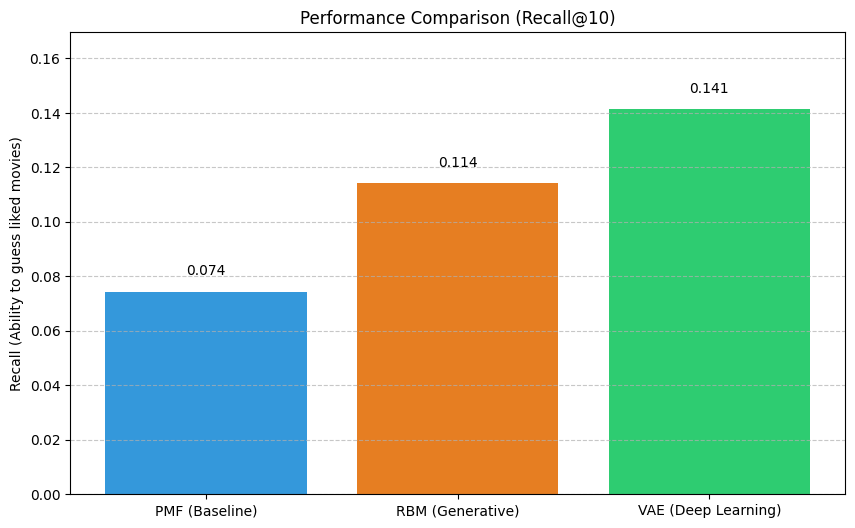

In [9]:
import matplotlib.pyplot as plt

models = ['PMF (Baseline)', 'RBM (Generative)', 'VAE (Deep Learning)']
results = [recall_pmf, recall_rbm, recall_vae]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, results, color=['#3498db', '#e67e22', '#2ecc71'])

# Add values above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 3), ha='center', va='bottom')

plt.title('Performance Comparison (Recall@10)')
plt.ylabel('Recall (Ability to guess liked movies)')
plt.ylim(0, max(results) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('model_comparison_recall.png')
plt.show()

--------------

In [10]:
from data.preprocess import get_movie_titles

movie_titles = get_movie_titles()

In [12]:
def display_recommendations(user_id):
    print(f"--- ANALYSIS OF USER {user_id} ---")
    
    # What the user has already liked (Input)
    liked_ids = train_df[(train_df.user_id == user_id) & (train_df.rating >= 4)].item_id.values
    print(f"\nMovies likes (training) :")
    for mid in liked_ids[:5]: # Display only the first 5 for readability
        print(f" - {movie_titles.get(mid, 'Unknown')}")
    
    # Recommendations
    for model_name in ['PMF', 'RBM', 'VAE']:
        if model_name == 'PMF': m = pmf_model
        elif model_name == 'RBM': m = rbm_model
        else: m = vae_model
            
        recs = get_top_n(user_id, m, model_name, n=5)
        
        print(f"\nTOP 5 RECOMMENDATIONS - {model_name} :")
        for mid in recs:
            print(f" > {movie_titles.get(mid, 'Unknown')}")

# Test on user 42
display_recommendations(42)

--- ANALYSIS OF USER 42 ---

Movies likes (training) :
 - Unforgiven (1992)
 - Tin Cup (1996)
 - Wrong Trousers, The (1993)
 - Close Shave, A (1995)
 - Adventures of Robin Hood, The (1938)

TOP 5 RECOMMENDATIONS - PMF :
 > Casablanca (1942)
 > Rear Window (1954)
 > To Kill a Mockingbird (1962)
 > Pather Panchali (1955)
 > Apt Pupil (1998)

TOP 5 RECOMMENDATIONS - RBM :
 > Godfather, The (1972)
 > One Flew Over the Cuckoo's Nest (1975)
 > Blade Runner (1982)
 > Psycho (1960)
 > Toy Story (1995)

TOP 5 RECOMMENDATIONS - VAE :
 > Terminator, The (1984)
 > To Kill a Mockingbird (1962)
 > Casablanca (1942)
 > Blade Runner (1982)
 > Wizard of Oz, The (1939)
